## Generating Embeddings with BERT (Bidirectional Encoder Representations from Transformers) 

### What is BERT?
BERT is a large state-of-the-art neural network that has been trained on a large corpora of text (millions of sentences). Its applications include but are not limited to:

- Sentiment analysis
- Text classification
- Question answering systems
 
In this notebook, we walk through how BERT generates fixed-length embeddings (features) from a sentence. You could think of these embeddings as an alternate feature extraction technique compared to bag of words. The BERT model has 2 main components as shown below 



## 1. Tokenizer (Converting sentences into series of numerical tokens):

The tokenizer in BERT is like a translator that converts sentences into a series of numerical tokens that the BERT model can understand. Specifically, it does the following:

- Splits Text: It breaks down sentences into smaller pieces called tokens. These tokens can be as short as one character or as long as one word. For example, the word "chatting" might be split into "chat" and "##ting".

- Converts Tokens to IDs: Each token has a unique ID in BERT's vocabulary. The tokenizer maps every token to its corresponding ID. This is like looking up the "meaning" of the word in BERT's dictionary.

- Adds Special Tokens: BERT requires certain special tokens for its tasks, like [CLS] at the beginning of a sentence and [SEP] at the end or between two sentences. The tokenizer adds these in.


### Example usage of the tokenizer

In the cell below, we see how BERT tokenizes 3 sentences and decodes them back.

We'll use the following example sentences:

1. "The sky is blue."
2. "Sky is clear today."
3. "Look at the clear blue sky."


In [1]:
# Import required libraries
from transformers import AutoTokenizer

# # Load pre-trained BERT tokenizer and model
sentences = ["The sky is blue.", "Sky is clear today.", "Look at the clear blue sky."]
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_text = tokenizer(sentences, padding=True,
                         max_length=10,
                         truncation=True)['input_ids']

print('----------------------------------------------')
print('Examples of tokenizing the sentences with BERT')
print('----------------------------------------------')
for jj, txt in enumerate(sentences):
    print('%s is enocoded as : %s'%(txt, encoded_text[jj]))

print('----------------------------------------------')
print('Examples of decoding the tokens back to English')
print('----------------------------------------------')
for enc in encoded_text:
    decoded_text = tokenizer.decode(enc)
    print("Decoded tokens back into text: ", decoded_text)

## 2. Model (Extracting meaningful feature representations from the sentences):

Once the text is tokenized and converted into the necessary format, it's fed into the BERT model. 
The **model** processes these inputs to generate contextual embeddings or representations for each token. These representations can then be utilized for various downstream tasks like classification, entity recognition, and more.

In [2]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import pandas as pd
import os
# Initialize BERT tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_bert_embedding(sentence_list, pooling_strategy='cls'):
    embedding_list = []
    for nn, sentence in enumerate(sentence_list):
        if (nn%100==0)&(nn>0):
            print('Done with %d sentences'%nn)
        
        # Tokenize the sentence and get the output from BERT
        inputs = tokenizer(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        # Take the embeddings from the last hidden state (optionally, one can use pooling techniques for different representations)
        # Here, we take the [CLS] token representation as the sentence embedding
        last_hidden_states = outputs.last_hidden_state[0]
        
        # Pooling strategies
        if pooling_strategy == "cls":
            sentence_embedding = last_hidden_states[0]
        elif pooling_strategy == "mean":
            sentence_embedding = torch.mean(last_hidden_states, dim=0)
        elif pooling_strategy == "max":
            sentence_embedding, _ = torch.max(last_hidden_states, dim=0)
        else:
            raise ValueError(f"Unknown pooling strategy: {pooling_strategy}")
        
        embedding_list.append(sentence_embedding)
    return torch.stack(embedding_list)

sentence = [sentences[0]]
embedding = get_bert_embedding(sentence)

np.set_printoptions(precision=3, suppress=True)
print('-----------------------------------------------------------------------------------------------------------')
print('The sentence "%s" has been converted to a feature representation of shape %s'%(sentence[0], embedding.numpy().shape))
print('-----------------------------------------------------------------------------------------------------------')
print(embedding.numpy()[0])

In [3]:
print('Loading data...')
x_train_df = pd.read_csv('../data_reviews/x_train.csv')
x_test_df = pd.read_csv('../data_reviews/x_test.csv')

tr_text_list = x_train_df['text'].values.tolist()
te_text_list = x_test_df['text'].values.tolist()

In [4]:
print('Generating embeddings for train sequences...')
tr_embedding = get_bert_embedding(tr_text_list)

print('Generating embeddings for test sequences...')
te_embedding = get_bert_embedding(te_text_list)


In [5]:
tr_embeddings_ND = tr_embedding.numpy()
te_embeddings_ND = te_embedding.numpy()

save_dir = os.path.abspath('../data_reviews/')
print('Saving the train and test embeddings to %s'%save_dir)

np.save(os.path.join(save_dir, 'x_train_BERT_embeddings.npy'), tr_embeddings_ND)
np.save(os.path.join(save_dir, 'x_test_BERT_embeddings.npy'), te_embeddings_ND)

In [48]:
import numpy as np
import os
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [42]:
# Load the precomputed BERT embeddings
train_embeddings = np.load(os.path.join(save_dir, 'x_train_BERT_embeddings.npy'))
test_embeddings = np.load(os.path.join(save_dir, 'x_test_BERT_embeddings.npy'))

# Load the labels (we only have y_train, so we'll still fit on it)
y_train_df = pd.read_csv('../data_reviews/y_train.csv')
y_train = y_train_df['is_positive_sentiment'].values

# Standardize the embeddings before training SVC
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_embeddings)
X_test_scaled = scaler.transform(test_embeddings)

## Show similarity between reviews using the embeddings

In [43]:
# Train SVC (you can tune hyperparameters via GridSearchCV later if needed) 9min
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# Initialize SVC
svc = SVC(class_weight='balanced', probability=True)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=svc, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=5
)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='roc_auc')

In [44]:
# Retrieve the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation AUC: ", grid_search.best_score_)

# # Use the best estimator from GridSearchCV to make predictions
best_svc = grid_search.best_estimator_

Best parameters found:  {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation AUC:  0.96721875


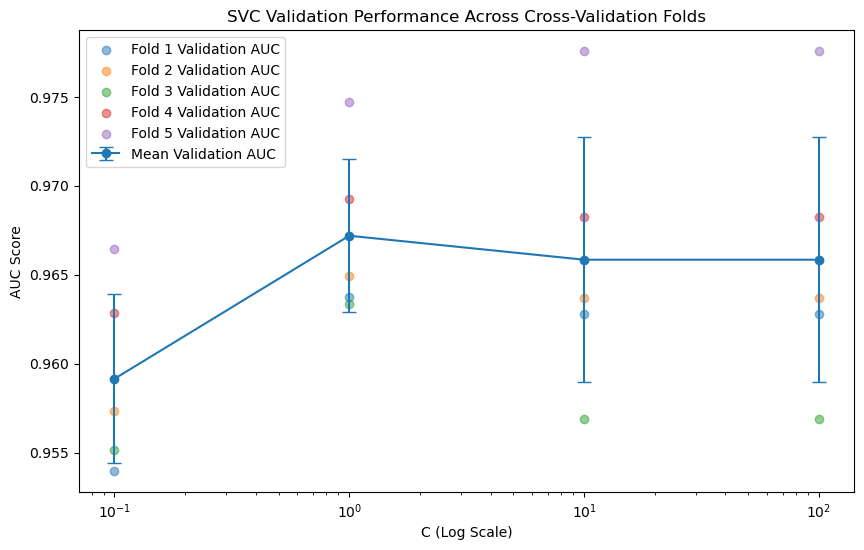

In [51]:
# Extract C values from the parameter grid
C_values = param_grid['C']

# Filter the cv_results_ for kernel='rbf' and gamma='scale'
mask = (grid_search.cv_results_['param_kernel'] == 'rbf') & (grid_search.cv_results_['param_gamma'] == 'scale')

# Apply the mask to get the relevant test scores
test_scores_mean = grid_search.cv_results_['mean_test_score'][mask]
test_scores_std = grid_search.cv_results_['std_test_score'][mask]

# Extract the individual split test scores (validation scores for each fold)
splits = 5  # Number of CV splits
test_scores_per_fold = []

for i in range(splits):
    test_scores_per_fold.append(grid_search.cv_results_[f'split{i}_test_score'][mask])

# Convert test scores to a NumPy array for easy plotting
test_scores_per_fold = np.array(test_scores_per_fold)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the mean validation scores with error bars
plt.errorbar(C_values, test_scores_mean, yerr=test_scores_std, label='Mean Validation AUC', fmt='o-', capsize=5)

# Add individual points for each fold's performance
for i in range(splits):
    plt.scatter(C_values, test_scores_per_fold[i], label=f'Fold {i+1} Validation AUC', alpha=0.5)

# Add labels, title, legend
plt.xscale('log')  # Logarithmic scale for C values
plt.xlabel('C (Log Scale)')
plt.ylabel('AUC Score')
plt.title('SVC Validation Performance Across Cross-Validation Folds')
plt.legend(loc='best')

# Show plot
plt.show()

In [69]:
print(grid_search.n_splits_)
print(grid_search.classes_)
print(grid_search.__getstate__)
print(grid_search.__format__)
print(grid_search.__init__)
print(grid_search)

5
[0 1]
<bound method BaseEstimator.__getstate__ of GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='roc_auc')>
<built-in method __format__ of GridSearchCV object at 0x3052a3310>
<bound method GridSearchCV.__init__ of GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='roc_auc')>


In [38]:
# Make predictions (probabilities) for training set
y_pred_prob_train = best_svc.predict_proba(X_train_scaled)[:, 1]
auc_train = roc_auc_score(y_train, y_pred_prob_train)
print(f'Training AUC: {auc_train:.4f}')


# Calculate AUC for the training set
auc_train = roc_auc_score(y_train, y_pred_prob_train)
print(f'Training AUC: {auc_train:.4f}')

# Make predictions on test set
y_pred_prob_test = best_svc.predict_proba(X_test_scaled)[:, 1] 

Training AUC: 0.9967
Training AUC: 0.9967


In [72]:
# Get predicted probabilities for the training set
y_pred_prob_train = best_svc.predict_proba(X_train_scaled)[:, 1]  # Only the positive class probabilities
pd.set_option('display.max_colwidth', None)  # None will display all content without truncation


# Create a DataFrame for analysis on the training set
results_train_df = pd.DataFrame({
    'True': y_train,                     # True labels
    'Predicted': y_pred_prob_train,      # Predicted probabilities for the positive class
    'Review': x_train_df['text'].values.tolist()                     # Assuming texts contains review texts
})

# Identify false positives and false negatives on the training set
false_positives_train = results_train_df[(results_train_df['True'] == 0) & (results_train_df['Predicted'] >= 0.5)]  # Change this to >= 0.5 for binary classification
false_negatives_train = results_train_df[(results_train_df['True'] == 1) & (results_train_df['Predicted'] < 0.5)]   # Change this to < 0.5 for binary classification

# Display examples of false positives and false negatives from the training set
print("False Positives (Train):")
print(false_positives_train[['Review', 'True', 'Predicted']].head(5))  # Show first 5 examples

print("\nFalse Negatives (Train):")
print(false_negatives_train[['Review', 'True', 'Predicted']].head(5))  # Show f

False Positives (Train):
                                                                                                 Review  \
53  I really wanted the Plantronics 510 to be the right one, but it has too many issues for me.The good   
54                                                                  Excellent starter wireless headset.   
77                       Still Waiting...... I'm sure this item would work well.. if I ever recieve it!   
79                 Think it over when you plan to own this one!This sure is the last MOTO phone for me!   
89                                                                              We are sending it back.   

    True  Predicted  
53     0   0.764119  
54     0   0.927235  
77     0   0.793727  
79     0   0.836298  
89     0   0.575520  

False Negatives (Train):
                                                                                               Review  \
435  This is cool because most cases are just open there allowing the

In [57]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming 'texts' is a list of the original text data corresponding to your input features
texts = [...]  # Replace with your actual text data corresponding to X_train_scaled

# Get the best estimator from GridSearchCV
best_svc = grid_search.best_estimator_

# Retrieve the CV splitter used in GridSearchCV
cv = grid_search.cv  # Access the CV splitter

# Initialize lists to hold the train/test indices
train_indices = []
test_indices = []

# Get the indices for the first fold
for fold, (train_idx, test_idx) in enumerate(cv.split(X_train_scaled, y_train)):
    if fold == 0:  # Only get the first fold
        train_indices, test_indices = train_idx, test_idx
        break

# Extract the test data and labels for this fold
X_test_fold = X_train_scaled[test_indices]
y_test_fold = y_train[test_indices]
texts_test_fold = [texts[i] for i in test_indices]  # Corresponding text data

# Make predictions on the test fold
y_pred = best_svc.predict(X_test_fold)

# Identify false positives and false negatives
false_positives = []
false_negatives = []

for i in range(len(y_test_fold)):
    if y_pred[i] == 1 and y_test_fold[i] == 0:  # False Positive
        false_positives.append((texts_test_fold[i], y_pred[i], y_test_fold[i]))
    elif y_pred[i] == 0 and y_test_fold[i] == 1:  # False Negative
        false_negatives.append((texts_test_fold[i], y_pred[i], y_test_fold[i]))

# Display 10 examples of false positives and false negatives
print("False Positives:")
for text, pred, actual in false_positives[:10]:
    print(f"Predicted: {pred}, Actual: {actual}, Text: {text}")

print("\nFalse Negatives:")
for text, pred, actual in false_negatives[:10]:
    print(f"Predicted: {pred}, Actual: {actual}, Text: {text}")


AttributeError: 'int' object has no attribute 'split'

In [39]:
# Save predictions to a text file (y_proba1_test.txt)
output_file = os.path.join(save_dir, 'yproba1_test.txt')
np.savetxt(output_file, y_pred_prob_test, fmt='%.6f')

print(f'Predicted probabilities saved to {output_file}')

Predicted probabilities saved to /Users/manuelpena/Documents/Tufts/fifth_semester/cs135-24f-assignments/projectA/data_reviews/yproba1_test.txt
